# IMAGE CLASSIFICATION

### 1. Import Dataset

Dataset Aerial Image saya upload di Google Drive, lalu Saya tinggal menghubungkan Google Drive tersebut dengan Google Collab. Dengan function di bawah ini:

In [ ]:
#Mounting ke google drive
from google.colab import drive
drive.mount('mnt')

Mounted at mnt


Code di bawah ini berguna untuk mengekstrak file zip.

In [ ]:
!unzip /content/mnt/MyDrive/DLO_Dataset/Aerial_Image_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

### 2. Import Library

Berikut ini adalah beberapa Library yang akan dipakai untuk proses segmentasi.

In [ ]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

from tensorflow.math import log, reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

!pip install patchify
!pip install segmentation-models

import segmentation_models as sm
from patchify import patchify

import matplotlib.patches as mpatches

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.3 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


### 3. Dataset Preparation

Jadi, terdapat dua folder gambar yang bernama 'images' dan 'masks'. Kedua folder gambar tersebut terletak pada path berikut ini dengan patch_size sebesar 256.

In [ ]:
df = "/content/Forest Segmented/Forest Segmented/"
patch_size = 256

Kemudian akan diambil dataset masing - masing. Code di bawah ini untuk mengambil dataset 'images'

In [ ]:
image_dataset = []
for path, subdirs, files in os.walk(df):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):

                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

Nah, jumlah image pada dataset 'images' itu berjumlah sebanyak 5108

In [ ]:
print(len(image_dataset))

5108


Code di bawah ini untuk mengambil dataset masks

In [ ]:
mask_dataset = []
for path, subdirs, files in os.walk(df):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".jpg"):

                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [ ]:
print(len(mask_dataset))

5108


Dapat dilihat dari output di atas, bahwa jumlah image pada dataset 'masks' itu berjumlah sebanyak 5108.

Dikarenakan jumlah dataset yang terlalu banyak yaitu sebesar 5108 untuk masing - masing dataset. Jadi saya memutuskan hanya mengambil sebanyak 700 data saja untuk masing - masing dataset

In [ ]:
# !!! testing with small amount of patches
image_dataset = np.array(image_dataset[:700])
mask_dataset =  np.array(mask_dataset[:700])

In [ ]:
image_dataset = np.array(image_dataset)
print(image_dataset.shape)
mask_dataset =  np.array(mask_dataset)
print(mask_dataset.shape)

(700, 256, 256, 3)
(700, 256, 256, 3)


Output di atas merupakan rincian dari dataset yang akan digunakan untuk proses segmentasi lebih lanjut.

### 4. Dataset Visualization

#### Segmentasi
Segmentasi merupakan sebuah proses untuk menentukan pixel mana saja dalam sebuah citra yang merupakan proyeksi dari objek yang sama dalam suatu tempat. Segmentasi ini sendiri memiliki konsep yang sama persis seperti object detection perbedaannya terletak di menandai objek. Jika object detection hanya menandai objek dengan bounding box maka segmentasi menandai objek per pixel.
Kali ini Saya akan membahas mengenai Segmentasi semantik. Segmentasi semantik ini merupakan teknik segmentasi yang melakukan pelabelan tingkat pixel dengan kumpulan kategori objek dalam seluruh pixel gambar atau bisa dikatakan sebagai sebuah proses klasifikasi setiap piksel dari sebuah citra sebagai sebuah label kelas untuk memahami citra dalam tingkat per piksel. Label kelas yang yang dimaksud adalah kelas objek, seperti rumah, buku, manusia, dan lain-lain.


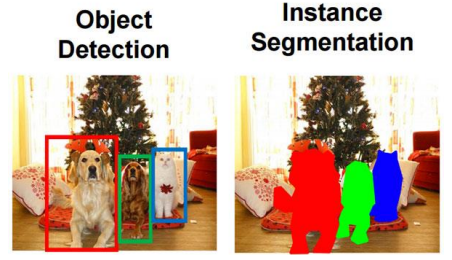

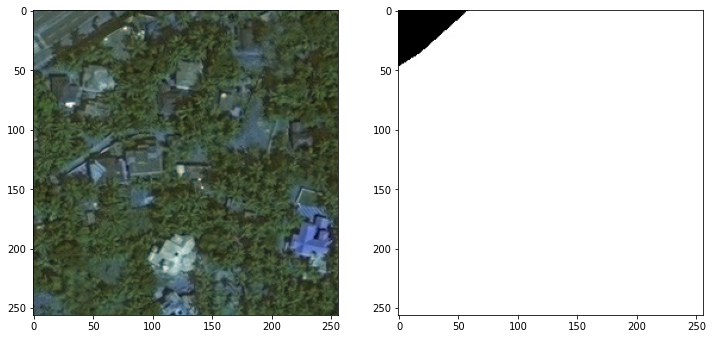

In [ ]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

Gambar di atas menunjukkan bahwa terjadi proses segmentasi semantik sederhana yang membedakan antara daratan dengan tumbuh - tumbuhan. Jadi bentuk pengenalannya itu dimana tumbuh - tumbuhan (warna hijau) diklasifikasikan sebagai warna putih sedangkan warna daratan (warna batu) diklasifikasikan sebagai warna hitam

Code di bawah ini digunakan untuk mewarnai berbagai objek yang akan dikenali, jadi beberapa objek di dalam gambar akan dikenali dan diberi warna masing - masing.

In [ ]:
Building = '#000000'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#000000'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#000000'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  '000000'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = '#000000'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#000000'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

Code di bawah ini untuk mengganti nilai RGB ke integer kemudian akan digunakan sebagai label. Caranya yaitu dengan menemukan piksel dengan kombinasi RGB untuk array yang ditentukan di code sebelumnya. Jika cocok maka ganti semua nilai dalam piksel itu dengan bilangan bulat tertentu.

In [ ]:
# !!! two class segmentation

label = single_patch_mask

def rgb_to_2D_label(label):
  label_seg = np.zeros(label.shape,dtype=np.uint8)
  label_seg [np.all(label == Building,axis=-1)] = 0
  label_seg [np.all(label==Land,axis=-1)] = 1
  label_seg [np.all(label==Road,axis=-1)] = 2
  label_seg [np.all(label==Vegetation,axis=-1)] = 3
  label_seg [np.all(label==Water,axis=-1)] = 4
  label_seg [np.all(label==Unlabeled,axis=-1)] = 5

  label_seg = label_seg[:,:,0]
  return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels.shape

(700, 256, 256)

In [ ]:
labels = np.expand_dims(labels, axis=3)
labels.shape

(700, 256, 256, 1)

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 5]


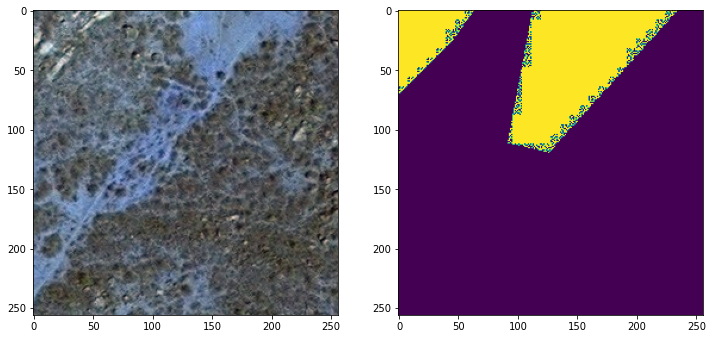

In [ ]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

Seperti yang dapat dilihat pada gambar di atas bahwa proses segmentasi sudah terjadi namun masih belum sempurna karena ada beberapa yang blm bisa diklasifikasian.

### 5. Model 1 (Tanpa Attention)

In [ ]:
labels_cat = to_categorical(labels)
labels_cat.shape

(700, 256, 256, 6)

Seperti biasa dilakukan split data untuk training dan testing dengan test size sebesar 0.20 dan sisanya untuk training.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Arsitektur U-Net

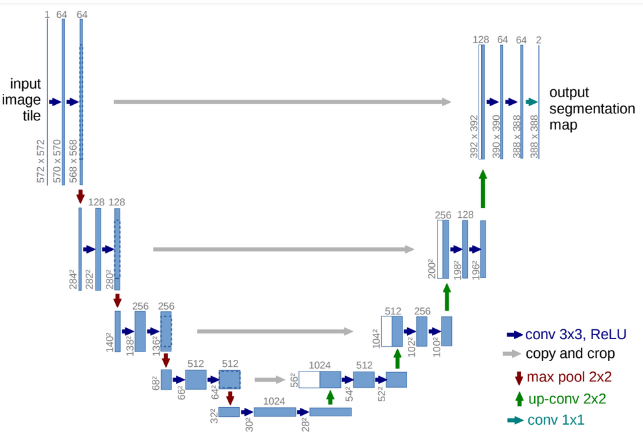

Dengan melihat sekilas arsitektur yang ditunjukkan pada gambar di atas, dapat diketahui bahwa jaringan yang dibangun adalah jaringan yang fully connected. Mereka belum menggunakan lapisan lain seperti dense, flatten atau sejenisnya. Representasi visual menunjukkan jalur kontraksi awal diikuti dengan jalur yang meluas

Arsitektur menunjukkan bahwa gambar hasil input dilewatkan melalui model dan kemudian diikuti oleh beberapa lapisan konvolusi dengan fungsi aktivasi berupa ReLU. Kita dapat melihat bahwa ukuran gambar berkurang dari 572x572 menjadi 570x570 dan akhirnya menjadi 568x568, setelah itu dilakukan max pool dengan stride 2x2 sehingga ukuran gambar menjadi 284 setelah itu masuk ke lapisan konvolusi lagi dengan fungsi aktivasi berupa ReLU dan seterusnya. Alasan dilakukan reduksi ini dikarenakan mereka menggunakan konvolusi yang tidak dilapisi (mendefinisikan konvolusi sebagai "valid") yang menghasilkan reduksi dimensi keseluruhan. Terlepas dari blok convolution, perlu diperhatikan bahwa terdapat blok encoder di sisi kiri diikuti oleh blok decoder di sisi kanan.

In [ ]:
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model= multi_unet_model(n_classes=6, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      4640      
                                                             

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/5
35/35 [==============================] - 431s 12s/step - loss: 1.0139 - accuracy: 0.4307 - jacard_coef: 0.1858 - val_loss: 0.9877 - val_accuracy: 0.5950 - val_jacard_coef: 0.2648
Epoch 2/5
35/35 [==============================] - 428s 12s/step - loss: 0.9837 - accuracy: 0.5535 - jacard_coef: 0.3285 - val_loss: 0.9802 - val_accuracy: 0.6152 - val_jacard_coef: 0.3369
Epoch 3/5
35/35 [==============================] - 431s 12s/step - loss: 0.9817 - accuracy: 0.5685 - jacard_coef: 0.3419 - val_loss: 0.9802 - val_accuracy: 0.6152 - val_jacard_coef: 0.3395
Epoch 4/5
35/35 [==============================] - 417s 12s/step - loss: 0.9812 - accuracy: 0.5806 - jacard_coef: 0.3448 - val_loss: 0.9800 - val_accuracy: 0.6152 - val_jacard_coef: 0.3399
Epoch 5/5
35/35 [==============================] - 405s 12s/step - loss: 0.9808 - accuracy: 0.5868 - jacard_coef: 0.3448 - val_loss: 0.9798 - val_accuracy: 0.6150 - val_jacard_coef: 0.3408


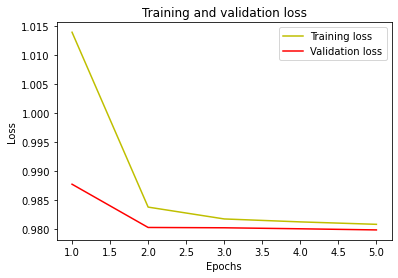

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Jika dilihat pada grafik dan hasil output di atas, dikatakan bahwa hasil akurasi akan bagus apabila mendekati angka 1 dengan kata lain, semakin tinggi angkanya maka semakin bagus hasilnya. Hal ini berlaku sebaliknya untuk loss yang dimana semakin kecil angkanya (mendekati 0) maka hasil semakin bagus. Berdasarkan hasil output pada nilai epoch dapat dilihat bahwa nilai akurasi per epoch semakin naik sedangkan grafik di atas menunjukkan bahwa nilai loss semakin menurun. Maka dapat disimpulkan bahwa model ini sudah bagus.

Pada masalah deteksi objek, output yang dihasilkan berupa bounding box (kotak pembatas) hasil prediksi sistem terhadap objek yang telah ditentukan. Bounding box ini merepresentasikan posisi objek dalam sebuah gambar. Untuk mengevaluasi model deteksi objek yang telah kita latih terdapat beberapa cara, salah satu caranya adalah dengan menggunakan metode Intersection Over Union (IOU)

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

5/5 [==============================] - 23s 5s/step


In [ ]:
#Using built in keras function for IoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.30990508


In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 156ms/step


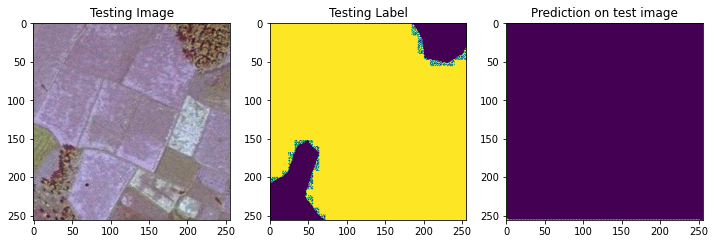

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

Hasil di atas menunjukkan bahwa prediction on test image entah mengapa kurang tepat.

### Model 2 (Dengan Attention)

Saya memilih mekanisme Hard Attention karena mekanisme ini dapat memilih fitur - fitur penting dari data, hal ini dianggap sebagai pendekatan yang lebih efisien

In [ ]:
def multi_unet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
model= multi_unet_model(n_classes=6, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/5
35/35 [==============================] - 505s 14s/step - loss: 1.0021 - accuracy: 0.4745 - jacard_coef: 0.2370 - val_loss: 0.9838 - val_accuracy: 0.6155 - val_jacard_coef: 0.3127
Epoch 2/5
35/35 [==============================] - 505s 14s/step - loss: 0.9835 - accuracy: 0.5582 - jacard_coef: 0.3297 - val_loss: 0.9792 - val_accuracy: 0.6740 - val_jacard_coef: 0.3446
Epoch 3/5
35/35 [==============================] - 505s 14s/step - loss: 0.9799 - accuracy: 0.6419 - jacard_coef: 0.3740 - val_loss: 0.9775 - val_accuracy: 0.7009 - val_jacard_coef: 0.4005
Epoch 4/5
35/35 [==============================] - 511s 15s/step - loss: 0.9785 - accuracy: 0.6718 - jacard_coef: 0.4000 - val_loss: 0.9765 - val_accuracy: 0.7174 - val_jacard_coef: 0.4173
Epoch 5/5
35/35 [==============================] - 505s 14s/step - loss: 0.9789 - accuracy: 0.6597 - jacard_coef: 0.3914 - val_loss: 0.9774 - val_accuracy: 0.6740 - val_jacard_coef: 0.3732


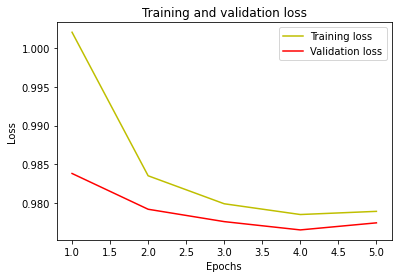

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Jika dilihat pada grafik dan hasil output di atas, dikatakan bahwa hasil akurasi akan bagus apabila mendekati angka 1 dengan kata lain, semakin tinggi angkanya maka semakin bagus hasilnya. Hal ini berlaku sebaliknya untuk loss yang dimana semakin kecil angkanya (mendekati 0) maka hasil semakin bagus. Berdasarkan hasil output pada nilai epoch dapat dilihat bahwa nilai akurasi per epoch semakin naik sedangkan grafik di atas menunjukkan bahwa nilai loss semakin menurun. Maka dapat disimpulkan bahwa model ini sudah bagus.

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

5/5 [==============================] - 27s 5s/step


In [ ]:
#Using built in keras function for IoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.49980623


In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 337ms/step


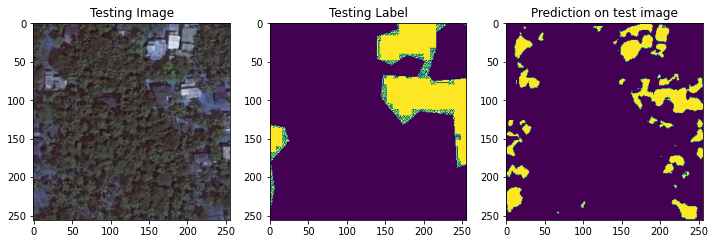

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

Output di atas menunjukkan bahwa model ini sudah sangat bagus. Hal ini terbukti pada hasil gambar di prediction on test image dimana dia sudah dapat membedakan antara daratan dengan hutan (pohon)

## Conclusion

Dari proses segmentasi pada kedua model, dapat dilihat bahwa model2 (Dengan Attention) menghasilkan output yang jauh lebih baik karena dapat dikatakan bahwa proses segmentasi semantik sudah sangat jelas. Dapat dilihat pada output di atas dimana Testing Image terdapat sebuah hutan serta beberapa tanah kemudian pada Testing Label hal ini mulai dikelompokkan dan pada Prediction on test_image semakin diperjelas lagi mana yg tanah dan mana yang hutan.

### Referensi:
https://www.kaggle.com/code/xxc025/attention-u-net/notebook

https://www.kaggle.com/code/ivanstar/aeriallmages-segmentation-baseline

https://www.kaggle.com/code/aymend/semantic-segmentation-of-aerial-satellite

https://blog.paperspace.com/unet-architecture-image-segmentation/

https://iopscience.iop.org/article/10.1088/1742-6596/1693/1/012173/pdf
